# Data Augmentation Pipeline

**Description**: Implements a synthetic data augmentation pipeline to generate variations of EEG signals using the following methods:
1. **Noise**: Add noise to the data
2. **Time Warping**: Alters the temporal properties of the signal.
3. **Time Drifting**: Add drift to simulate gradual shifts over time
4. **Time Croping**: Crop the time-series to 90% of its original length
5. **Amplitude Scaling**: Scales the amplitude of the signal.
6. **Autoencoder**: Reconstructs or augments EEG signals.
8. **Conditional Variational Autoencoder (CVAE)**: Generates augmented data conditioned on specific labels.

**Output**: A function with original signals and augmentation methods as input, and reconstructed EEG signals as output.

The data augmentation pipeline evaluates seizure detection model performance after applying various augmentation techniques, ensuring robustness and accuracy across diverse datasets.

In [24]:
# Import necessary libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tsaug import AddNoise, TimeWarp, Drift, Crop

from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, Conv1DTranspose, Dropout, Dense, Flatten

gpus = tf.config.list_physical_devices('GPU')
device = '/device:GPU:0' if gpus else '/device:CPU:0'
print(f"Using device: {device}")

# load models
autoencoder = load_model("../models/autoencoder.h5")

Using device: /device:GPU:0


In [25]:
cvae_decoder = load_model('../models/CVAE/cvae_decoder_model')

In [26]:
cvae_class_embedding_model = load_model('../models/CVAE/class_embedding_model')

In [27]:
embedded_class_labels = cvae_class_embedding_model.predict(np.array([[1]] * 1))  # Shape (n_samples, latent_dim)

1/1 [==============================] - 0s 44ms/step


In [3]:
# Load data
def load_train_hard_test_split():
    train_data = pd.read_csv('../data/hard_test_cases/train.csv', index_col=0)
    test_data = pd.read_csv('../data/hard_test_cases/test.csv', index_col=0)

    X_train = train_data.iloc[:, :-1].values  # X1-X178
    X_test = test_data.iloc[:, :-1].values    # X1-X178

    # Normalize the data using min-max scaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the data for the model
    X_train_scaled = X_train_scaled.reshape(-1, 178, 1)
    X_test_scaled = X_test_scaled.reshape(-1, 178, 1)

    # y data
    y_train = train_data['y']
    y_test = test_data['y']
    y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
    y_test = y_test.values if isinstance(y_test, pd.Series) else y_test
    
    return X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler

X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler = load_train_hard_test_split()

In [4]:
# Visualization signal
def visualize_augmentation(original_signal, augmented_signal, title="Augmented Signal"):
    """
    Visualize the original and augmented signals on the same plot.

    Parameters:
    - original_signal: numpy array, the original time-series signal.
    - augmented_signal: numpy array, the augmented time-series signal.
    - title: str, title for the plot.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(original_signal, label="Original Signal", color="blue", alpha=0.7)
    plt.plot(augmented_signal, label="Augmented Signal", color="red", alpha=0.7)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

original_signal = X_train_scaled[0].flatten()

## I. Visualization of the augmented signal

### 1. Add noise

In [5]:
# Augmentation functions
def add_noise(original_signal, scale=0.1):
    """
    Add random Gaussian noise to the signal.

    Parameters:
    - original_signal: numpy array, the original signal.
    - scale: float, standard deviation of the Gaussian noise.

    Returns:
    - augmented_signal: numpy array, signal with added noise.
    """
    augmenter = AddNoise(scale=scale)
    return augmenter.augment(original_signal)

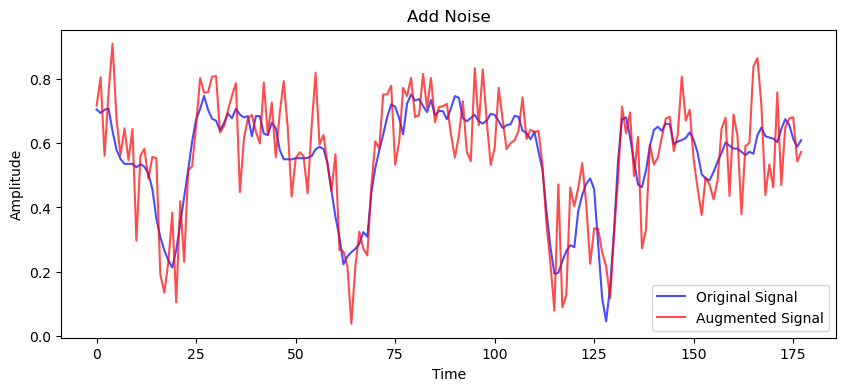

In [7]:
# Augmentations
augmented_noise = add_noise(original_signal, scale=0.15)
# Visualizations
visualize_augmentation(original_signal, augmented_noise, title="Add Noise")

### 2. Time Warping
Alters the temporal properties of the signal.

In [8]:
def time_warp(original_signal, n_speed_change=2):
    """
    Apply time warping to the signal.

    Parameters:
    - original_signal: numpy array, the original signal.
    - n_speed_change: int, number of speed changes in the time-series.

    Returns:
    - augmented_signal: numpy array, time-warped signal.
    """
    augmenter = TimeWarp(n_speed_change=n_speed_change)
    return augmenter.augment(original_signal)

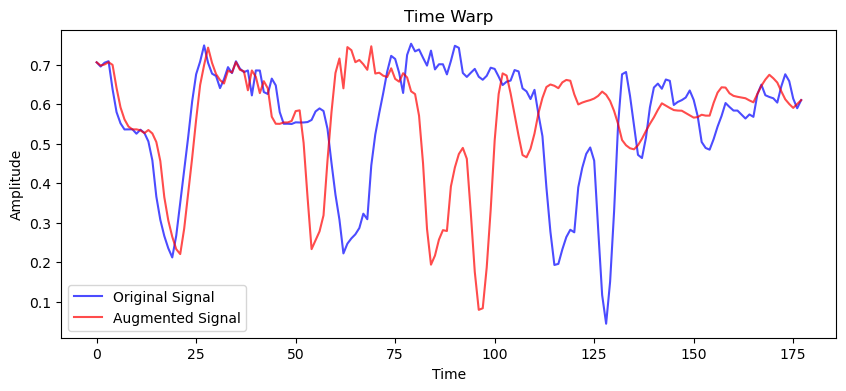

In [9]:
augmented_warp = time_warp(original_signal, n_speed_change=3)
visualize_augmentation(original_signal, augmented_warp, title="Time Warp")

### 3. Time Drifting
Add drift to simulate gradual shifts over time

In [10]:
def time_drift(original_signal, max_drift=(0.1, 0.5)):
    """
    Add drift to the signal to simulate baseline shifts.

    Parameters:
    - original_signal: numpy array, the original signal.
    - max_drift: tuple, range of drift values.

    Returns:
    - augmented_signal: numpy array, drifted signal.
    """
    augmenter = Drift(max_drift=max_drift)
    return augmenter.augment(original_signal)

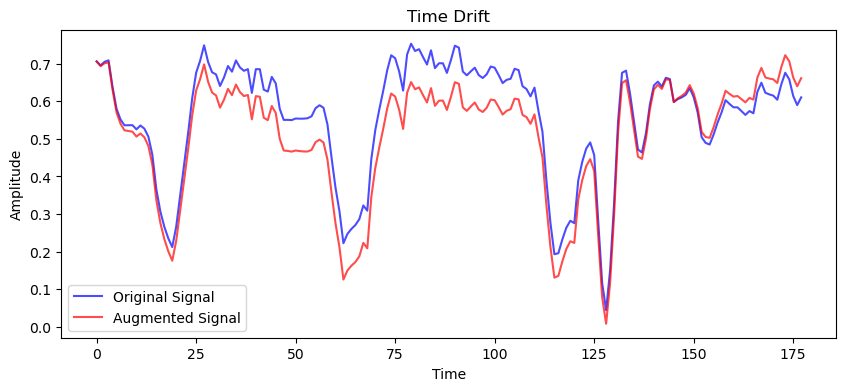

In [11]:
augmented_drift = time_drift(original_signal, max_drift=(0.1, 0.3))
visualize_augmentation(original_signal, augmented_drift, title="Time Drift")

### 4. Time Croping
Crop the time-series to 90% of its original length

In [12]:
def time_crop(original_signal, size_ratio=0.9):
    """
    Crop the time-series to a smaller size and pad with zeros.

    Parameters:
    - original_signal: numpy array, the original signal.
    - size: float, proportion of the signal to keep (0 < size <= 1).

    Returns:
    - augmented_signal: numpy array, cropped signal.
    """
    original_length = len(original_signal)
    crop_size = int(original_length * size_ratio)  # Calculate the target size as an integer
    augmenter = Crop(size=crop_size)  # Use the integer size
    cropped_signal = augmenter.augment(original_signal)
    padding = original_length - len(cropped_signal)
    return np.pad(cropped_signal, (0, padding), mode="constant")

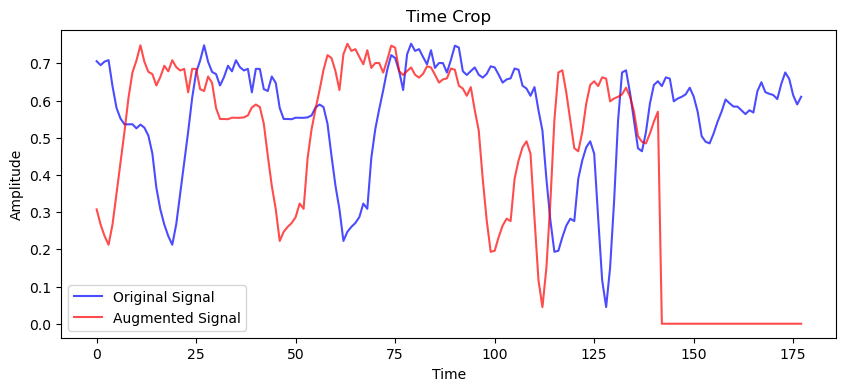

In [13]:
augmented_crop = time_crop(original_signal, size_ratio=0.8)
visualize_augmentation(original_signal, augmented_crop, title="Time Crop")

### 5. Amplitude Scaling
Scales the amplitude of the signal.

In [14]:
def amplitude_scaling(original_signal, factor=1.5):
    """
    Scale the amplitude of the signal.

    Parameters:
    - original_signal: numpy array, the original signal.
    - factor: float, scaling factor.

    Returns:
    - augmented_signal: numpy array, scaled signal.
    """
    return original_signal * factor

In [15]:
def permute_signal(original_signal, n_segments=5):
    """
    Permute a signal by dividing it into segments and randomly shuffling them.

    Parameters:
    - original_signal: numpy array, the original time-series signal.
    - n_segments: int, number of segments to divide the signal into.

    Returns:
    - permuted_signal: numpy array, the permuted time-series signal.
    """
    segment_size = len(original_signal) // n_segments
    segments = [
        original_signal[i * segment_size:(i + 1) * segment_size]
        for i in range(n_segments)
    ]
    np.random.shuffle(segments)  # Shuffle the segments randomly
    return np.concatenate(segments)

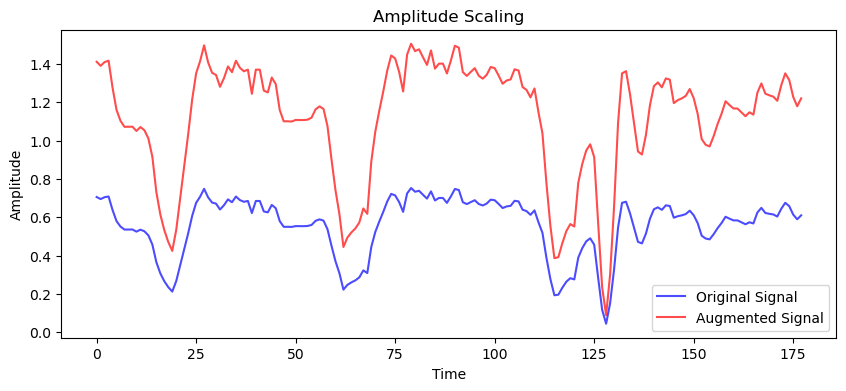

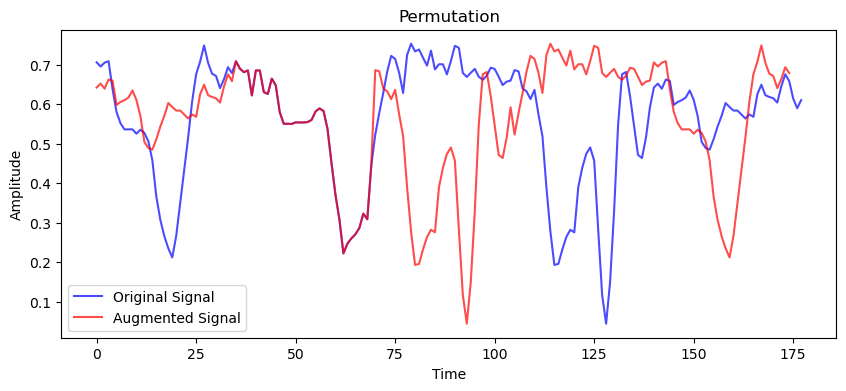

In [16]:
augmented_scale = amplitude_scaling(original_signal, factor=2.0)
augmented_permute = permute_signal(original_signal, n_segments=5)
visualize_augmentation(original_signal, augmented_scale, title="Amplitude Scaling")
visualize_augmentation(original_signal, augmented_permute, title="Permutation")

### 6. Autoencoder
Reconstructs or augments EEG signals.

In [17]:
def autoencoder_augment(signal, autoencoder):
    return np.squeeze(autoencoder.predict(signal[np.newaxis, :, np.newaxis], verbose=0))

2024-11-28 19:28:55.296619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-11-28 19:28:55.737542: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-28 19:28:55.737602: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-28 19:28:55.806644: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

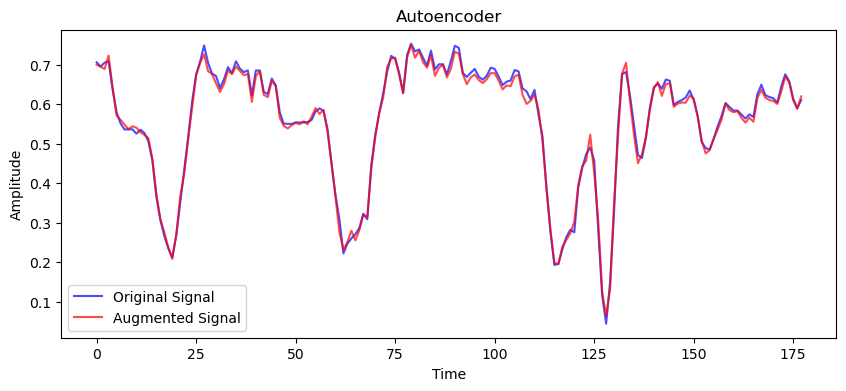

In [18]:
reconstructed_scaled = autoencoder_augment(original_signal, autoencoder)
visualize_augmentation(original_signal, reconstructed_scaled.squeeze(), title="Autoencoder")

### 7. Conditional VAE
Generates augmented data conditioned on specific labels.

In [48]:
def conditional_vae_augment(signal, cvae_decoder, class_embedding_model, class_value, n_samples=1):
    """
    Generates synthetic data using the CVAE decoder for a specific class.
    
    Args:
    cvae_decoder: model 
    class_value (int): Class label for which to generate synthetic data.
    n_samples (int): Number of synthetic samples to generate.

    Returns:
    np.ndarray: Generated synthetic
    """
    latent_dim = 32

    # Prepare the class labels array as input, repeating it n_samples times
    class_label_input = np.array([[class_value]] * n_samples)  # Shape (n_samples, 1)

    # Embed the class labels using the same embedding layer as in the encoder
    embedded_class_labels = class_embedding_model.predict(class_label_input)  # Shape (n_samples, latent_dim)

    # Generate random samples from the latent space with randomness each time
    latent_samples = np.random.normal(loc=0, scale=3, size=(n_samples, latent_dim))  # Shape (n_samples, latent_dim)

    # Concatenate latent samples with embedded class labels
    latent_samples_with_class = np.concatenate([latent_samples, embedded_class_labels], axis=-1)  # Shape (n_samples, latent_dim + latent_dim)

    # Generate synthetic data using the decoder
    synthetic_data = cvae_decoder.predict(latent_samples_with_class)  # Shape (n_samples, 178, 1)

    return np.squeeze(synthetic_data)

1/1 [==============================] - 0s 21ms/step


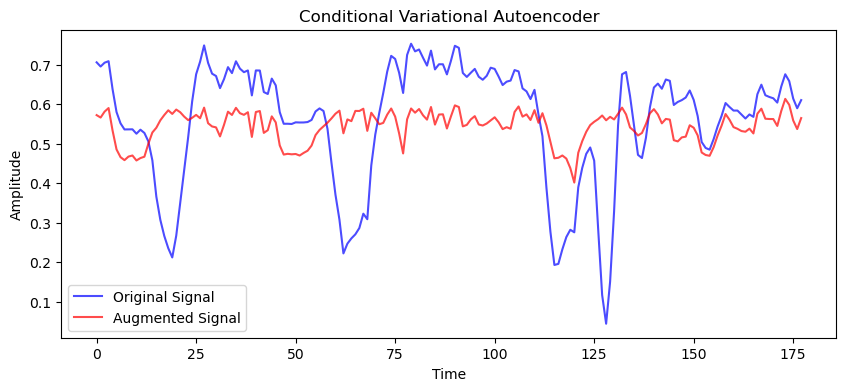

In [49]:
reconstructed_scaled = conditional_vae_augment(original_signal, cvae_decoder, cvae_class_embedding_model, 1, 1)
visualize_augmentation(original_signal, reconstructed_scaled.squeeze(), title="Conditional Variational Autoencoder")

## II. Data Augmentation Pipeline

In [50]:
def augmentation_pipeline(signal, autoencoder=None, cvae_model=None, class_embedding_model=None, label=None, n_augmentations=3):
    augmentations = {
        "Add Noise": lambda x: add_noise(x, scale=0.1),
        "Time Warp": lambda x: time_warp(x, n_speed_change=3),
        "Time Drift": lambda x: time_drift(x, max_drift=(0.1, 0.3)),
        "Time Crop": lambda x: time_crop(x, size_ratio=0.9),
        "Amplitude Scaling": lambda x: amplitude_scaling(x, factor=1.2),
        "Autoencoder Augment": lambda x: autoencoder_augment(x, autoencoder) if autoencoder else x,
        "Conditional VAE Augment": lambda x: conditional_vae_augment(x, cvae_model, class_embedding_model, label, 1) if cvae_model else x
    }

    # Randomly choose 3 augmentations for each signal
    selected_augmentations = random.sample(list(augmentations.items()), n_augmentations)

    augmented_signals = []
    augmentation_names = []
    for name, augmentation in selected_augmentations:
        augmented_signals.append(augmentation(signal))
        augmentation_names.append(name)

    return augmented_signals, augmentation_names

In [51]:
def visualize_augmentations(original_signal, augmented_signals, augmentation_names, title="Augmented Signals"):
    """
    Visualize the original and multiple augmented signals on the same plot.

    Parameters:
    - original_signal: numpy array, the original time-series signal.
    - augmented_signals: list of numpy arrays, the augmented time-series signals.
    - augmentation_names: list of str, names of the applied augmentations.
    - title: str, title for the plot.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot the original signal
    plt.plot(original_signal, label="Original Signal", color="red", alpha=0.7, linewidth=2)
    
    # Plot each augmented signal with its corresponding augmentation name
    for i, (augmented_signal, name) in enumerate(zip(augmented_signals, augmentation_names)):
        plt.plot(augmented_signal, label=f"{name}", alpha=0.7, linestyle='--')
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

1/1 [==============================] - 0s 20ms/step


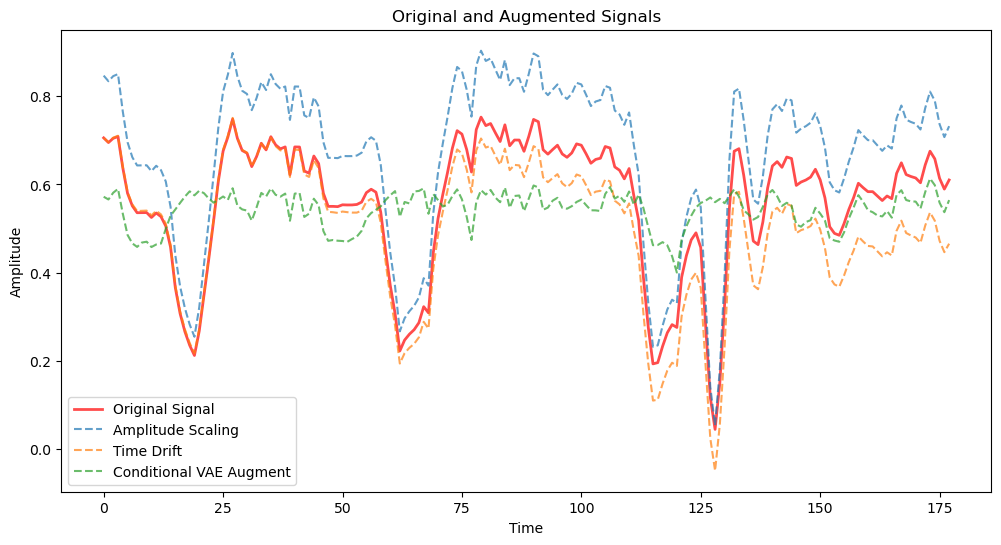

In [54]:
augmented_signals, augmentation_names = augmentation_pipeline(original_signal, autoencoder=autoencoder, cvae_model=cvae_decoder, class_embedding_model=cvae_class_embedding_model, label=1, n_augmentations=3)
visualize_augmentations(original_signal, augmented_signals, augmentation_names, title="Original and Augmented Signals")

## III. Evaluation of Data Augmentation Pipeline

In [55]:
def evaluate_classification_metrics(y_true, y_pred, y_pred_prob):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate precision
    precision = precision_score(y_true, y_pred)
    
    # Calculate recall
    recall = recall_score(y_true, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    if len(set(y_true)) > 1:
        # Check if ROC-AUC can be calculated (i.e., both classes are present)
        roc_auc = roc_auc_score(y_true, y_pred_prob)
        # Calculate Cohen's Kappa
        kappa = cohen_kappa_score(y_true, y_pred)
    else:
        roc_auc = None  # Not computable, only one class in y_true
        kappa = None
    
    # Calculate metrics for seizure class (y_label=1)
    precision_seizure = precision_score(y_true, y_pred, pos_label=1)
    recall_seizure = recall_score(y_true, y_pred, pos_label=1)
    f1_seizure = f1_score(y_true, y_pred, pos_label=1)
    
    # Calculate metrics for non-seizure class (y_label=0)
    precision_non_seizure = precision_score(y_true, y_pred, pos_label=0)
    recall_non_seizure = recall_score(y_true, y_pred, pos_label=0)
    f1_non_seizure = f1_score(y_true, y_pred, pos_label=0)
    
    print(f'\nSeizure (y=1):')
    print(f'  Precision: {precision_seizure * 100:.2f} %')
    print(f'  Recall: {recall_seizure * 100:.2f} %')
    print(f'  F1 Score: {f1_seizure * 100:.2f} %')
    
    print(f'\nNon-Seizure (y=0):')
    print(f'  Precision: {precision_non_seizure * 100:.2f} %')
    print(f'  Recall: {recall_non_seizure * 100:.2f} %')
    print(f'  F1 Score: {f1_non_seizure * 100:.2f} %')
    
    # Print metrics
    print(f'\nOverall:')
    print(f'  Accuracy: {accuracy * 100:.2f} %')
    print(f'  Precision: {precision * 100:.2f} %')
    print(f'  Recall: {recall * 100:.2f} %')
    print(f'  F1 Score: {f1 * 100:.2f} %')
    if roc_auc is not None:
        print(f'  ROC-AUC: {roc_auc * 100:.2f} %')
    if kappa is not None:
        print(f'  Cohen\'s Kappa: {kappa * 100:.2f} %')

### Detection Model

- **Preprocessing**: No normalization. Since we are using challenging test cases, the scaler trained on the training dataset is completely different from the test set. Using the scaler to scale the test data would skew the results.
- **Feature**: Inception Nucleus.
- **Output Dimension**: 1 (Sigmoid activation).
- **Optimizer**: Adam.
- **Loss Function**: Cross-Entropy.
- **Early Stopping**: 5 epochs of patience.
- **Learning Rate**: 0.0001.

In [56]:
def InceptionNucleus(input_layer, filters):
    branches = []
    for f in filters:
        x = Conv1D(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def create_eeg_cnn(input_shape=(178, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Initial 1D Convolutional Layers with Inception Nucleus
    x = InceptionNucleus(inputs, filters=[4, 8, 12])

    # Reshape for 2D Convolutions
    x = Reshape((x.shape[1], x.shape[2], 1))(x) # (178, 96, 1) for example

    # 2D Convolutional Layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten after 2D Convolutions
    x = Flatten()(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [57]:
def train_and_test_classification(X_train, y_train, X_test, y_test, lr_rate=0.0001, num_epochs=30):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Create the model
    model = create_eeg_cnn(input_shape=(178, 1), num_classes=2)
    
    # Define the optimizer with a specific learning rate
    optimizer = Adam(learning_rate=lr_rate)
    
    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model and store the training history
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),  
        epochs=num_epochs, 
        batch_size=32,
        shuffle=True,
        callbacks=[early_stopping], 
        verbose=1 
    )
    
    # After training, evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    # Predict class probabilities for the test set
    y_pred_prob = model.predict(X_test)
    
    # Convert probabilities to binary class labels (assuming threshold 0.5)
    y_pred = (y_pred_prob[:, 1] > 0.5).astype(int)
    
    # Evaluate classification metrics using the provided function
    evaluate_classification_metrics(y_test, y_pred, y_pred_prob[:, 1])
    
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    
    # Plot training & validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


### Before augmentation

Epoch 1/30


2024-11-28 19:50:07.904767: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-28 19:50:08.051165: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f528ac15920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-28 19:50:08.051202: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-28 19:50:08.056192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-28 19:50:08.174276: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-

256/256 [==============================] - 8s 21ms/step - loss: 0.4281 - accuracy: 0.9672 - val_loss: 0.1343 - val_accuracy: 0.9868
Epoch 2/30
256/256 [==============================] - 5s 19ms/step - loss: 0.4273 - accuracy: 0.9773 - val_loss: 0.0922 - val_accuracy: 0.9927
Epoch 3/30
256/256 [==============================] - 5s 19ms/step - loss: 0.2805 - accuracy: 0.9839 - val_loss: 0.7974 - val_accuracy: 0.9678
Epoch 4/30
256/256 [==============================] - 5s 19ms/step - loss: 0.5273 - accuracy: 0.9784 - val_loss: 0.0907 - val_accuracy: 0.9941
Epoch 5/30
256/256 [==============================] - 5s 20ms/step - loss: 0.3483 - accuracy: 0.9849 - val_loss: 0.1511 - val_accuracy: 0.9927
Epoch 6/30
256/256 [==============================] - 5s 19ms/step - loss: 0.2132 - accuracy: 0.9853 - val_loss: 0.0869 - val_accuracy: 0.9961
Epoch 7/30
256/256 [==============================] - 5s 19ms/step - loss: 0.1922 - accuracy: 0.9893 - val_loss: 0.0226 - val_accuracy: 0.9976
Epoch 8/30

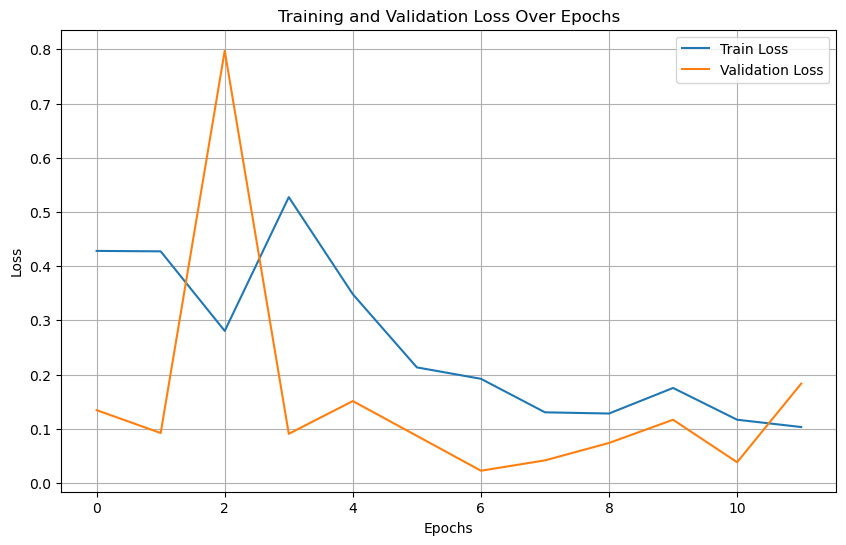

In [58]:
train_and_test_classification(X_train, y_train, X_test, y_test)

### After Augmentation
We use two approaches to generate augmented datasets:

1. **Balanced Training Dataset**:  
   Since the training dataset is imbalanced, with 80% non-seizure data and 20% seizure data, we augment only the seizure data. The augmentation continues until the training set contains an equal number of non-seizure and seizure samples.

2. **Augmenting the Entire Training Set**:  
   In this approach, we augment the entire training set by 5 times, increasing the variations in the dataset regardless of the labels.

In [59]:
def generate_augmented_data_entire_dataset(X_train, y_train, autoencoder, n_augmentations=3):
    # Reshape X_train if needed to ensure 3D shape (e.g., (samples, 178, 1))
    if X_train.ndim == 2:
        X_train = X_train[..., np.newaxis]

    # Initialize lists to store augmented data and labels
    augmented_X = []
    augmented_y = []

    # Add original data
    for x, y in zip(X_train, y_train):
        augmented_X.append(x.flatten())  # Flatten for saving as rows in CSV
        augmented_y.append(y)

    # Generate n_augmentations for each sample in X_train
    for i in tqdm(range(len(X_train)), desc="Generating augmentations"):
        original_signal = X_train[i].flatten()
        for _ in range(n_augmentations):
            # Use augmentation pipeline to generate augmentations
            augmented_signals, _ = augmentation_pipeline(
                original_signal, autoencoder=autoencoder, n_augmentations=n_augmentations
            )
            for aug_signal in augmented_signals:
                augmented_X.append(aug_signal)  # Add augmented signal
                augmented_y.append(y_train[i])  # Corresponding label

    # Convert lists to arrays
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)

    # Combine features and labels into a DataFrame
    augmented_df = pd.DataFrame(augmented_X)
    augmented_df['label'] = augmented_y
    print ("Label distribution in error cases (actual labels):\n", augmented_df['label'].value_counts())
    return augmented_X, augmented_y

In [60]:
# Augment the dataset
X_train_augmented, y_train_augmented = generate_augmented_data_entire_dataset(X_train, y_train, autoencoder, n_augmentations=2)

Generating augmentations:   0%|          | 0/10239 [00:00<?, ?it/s]

Generating augmentations: 100%|██████████| 10239/10239 [04:51<00:00, 35.10it/s]


Label distribution in error cases (actual labels):
 label
0    41375
1     9820
Name: count, dtype: int64


Epoch 1/30
1280/1280 [==============================] - 26s 20ms/step - loss: 1.0709 - accuracy: 0.9307 - val_loss: 0.1445 - val_accuracy: 0.9656
Epoch 2/30
1280/1280 [==============================] - 25s 19ms/step - loss: 0.5487 - accuracy: 0.9477 - val_loss: 0.1815 - val_accuracy: 0.9707
Epoch 3/30
1280/1280 [==============================] - 25s 19ms/step - loss: 0.3862 - accuracy: 0.9533 - val_loss: 0.5657 - val_accuracy: 0.8864
Epoch 4/30
1280/1280 [==============================] - 25s 19ms/step - loss: 0.2617 - accuracy: 0.9579 - val_loss: 0.1668 - val_accuracy: 0.9717
Epoch 5/30
1280/1280 [==============================] - 25s 19ms/step - loss: 0.2581 - accuracy: 0.9606 - val_loss: 0.3363 - val_accuracy: 0.9718
Epoch 6/30
1280/1280 [==============================] - 25s 19ms/step - loss: 0.1756 - accuracy: 0.9641 - val_loss: 0.1295 - val_accuracy: 0.9726
Epoch 7/30
1280/1280 [==============================] - 25s 19ms/step - loss: 0.1880 - accuracy: 0.9651 - val_loss: 0.0940 -

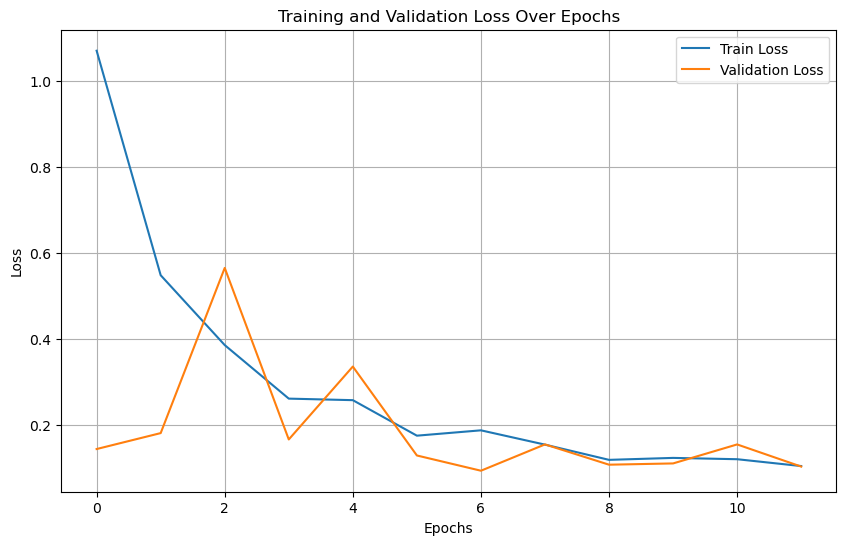

In [61]:
# Evaluate on detection task
train_and_test_classification(X_train_augmented, y_train_augmented, X_test, y_test)

# Conclusion

- We introduced a flexible data augmentation tool designed for enhancing time-series signals, such as EEG signals. The pipeline applies a variety of transformations to the input signal, either individually or in combination, to create diverse and realistic variations of the original data.
- 3 times of data augmentation improved all evaluation metrics, demonstrating its effectiveness in enhancing model performance for seizure detection.


### Metrics Before and After Augmentation:

| Metric                          | Before Augmentation | After Augmentation |
|---------------------------------|---------------------|--------------------|
| **Recall (Seizure Activity)**   | 52.68%              | **74.40%**            |
| **F1 Score (Detection)**        | 72.23%              | **74.39%**            |
| **ROC-AUC (Detection)**         | 74.14%             | **78.72%**            |
| **Cohen's Kappa (Detection)**   | 30.29%             | **40.50%**            |